In [1]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### aplicando o  Box-Jenkins pelo paper: https://support.sas.com/resources/papers/proceedings13/454-2013.pdf

#### dataset: https://www.kaggle.com/datasets/prashant111/dataset

In [3]:
data = pd.read_csv("dataset.txt")

In [4]:
serie = data["value"]
serie

0       3.526591
1       3.180891
2       3.252221
3       3.611003
4       3.565869
         ...    
199    21.654285
200    18.264945
201    23.107677
202    22.912510
203    19.431740
Name: value, Length: 204, dtype: float64

In [5]:
serie.isnull().sum()

0

In [6]:
duplicados = serie.duplicated()
serie[duplicados]

Series([], Name: value, dtype: float64)

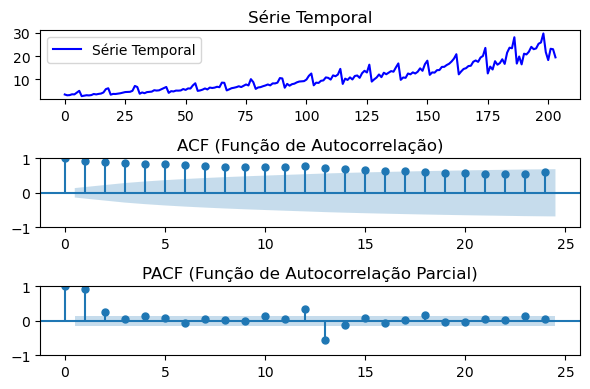

In [7]:

fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=False)

#serie
axes[0].plot(serie, label="Série Temporal", color="blue")
axes[0].set_title("Série Temporal")
axes[0].legend()

#acf
plot_acf(serie, ax=axes[1], lags=24, title="ACF (Função de Autocorrelação)")

#pacf
plot_pacf(serie, ax=axes[2], lags=24, title="PACF (Função de Autocorrelação Parcial)", method='ywm')


plt.tight_layout()
plt.show()

#### percebemos que essa serie tem variações sazonais, nesse caso antes de usar diferenciação para transformar a serie em
#### estacionaria, precisamos verificar se a serie possui variancia sazonal constante e usar tranformações para estabilizar
#### essa variancia

#### nesse caso percebemos que a variação sazonal nao é constante, vamos aplicar certas transformações

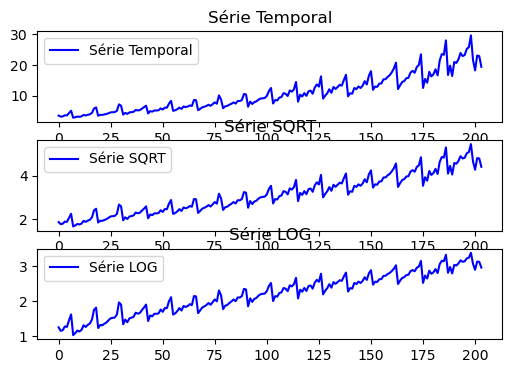

In [9]:
#vamos usar 2 transformações e verificar a variancia da sua sazonalidade, log e raiz quadrada:

# transf log
serie_log= np.log(serie)

# transf raiz quadrada
serie_sqrt = np.sqrt(serie)

fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=False)


axes[0].plot(serie, label="Série Temporal", color="blue")
axes[0].set_title("Série Temporal")
axes[0].legend()

axes[1].plot(serie_sqrt, label="Série SQRT", color="blue")
axes[1].set_title("Série SQRT")
axes[1].legend()


axes[2].plot(serie_log, label="Série LOG", color="blue")
axes[2].set_title("Série LOG")
axes[2].legend()




#### percebemos que a transformação log resultou em variancia mais proxima da constante(visualmente),
#### vamos analisar seu acf e pacf

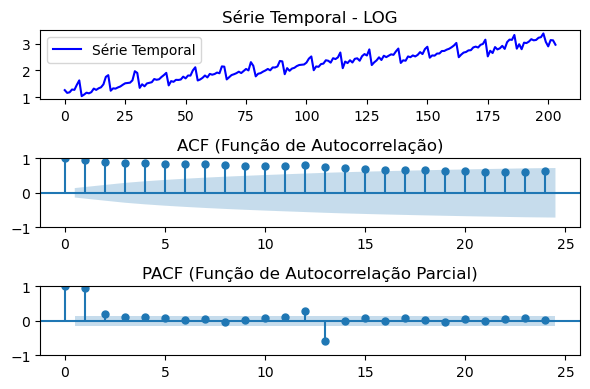

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=False)

axes[0].plot(serie_log, label="Série Temporal", color="blue")
axes[0].set_title("Série Temporal - LOG")
axes[0].legend()

#acf
plot_acf(serie_log, ax=axes[1], lags=24, title="ACF (Função de Autocorrelação)")

#pacf
plot_pacf(serie_log, ax=axes[2], lags=24, title="PACF (Função de Autocorrelação Parcial)", method='ywm')


plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(serie_log)

print('The test stastics:', result[0])

print("p-value:",result[1])

The test stastics: -0.9887334889479151
p-value: 0.7573512901699144


#### pelo grafico do acf e pelo teste de dick-fuller, percebemos que a serie nao é estacionaria

In [14]:
#para series sazonais, segundo o artigo, podemos usar tipos de diferenciações diferentes (Examinar)

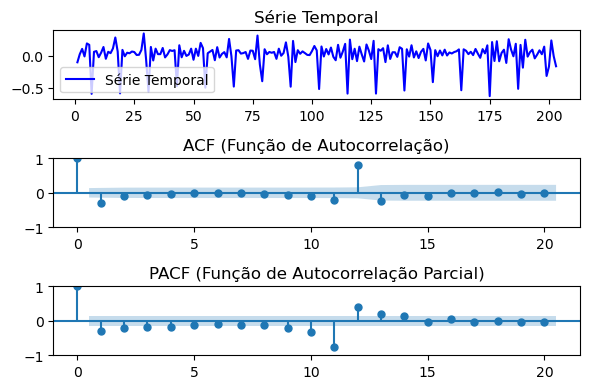

In [15]:
#1 dif:
serie_dif1 = serie_log.diff().dropna()


fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=False)


axes[0].plot(serie_dif1, label="Série Temporal", color="blue")
axes[0].set_title("Série Temporal")
axes[0].legend()

#acf
plot_acf(serie_dif1, ax=axes[1], lags=20, title="ACF (Função de Autocorrelação)")

#pacf
plot_pacf(serie_dif1, ax=axes[2], lags=20, title="PACF (Função de Autocorrelação Parcial)", method='ywm')



plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller


result1 = adfuller(serie_dif1)

print('The test stastics:', result1[0])

print("p-value:",result1[1])

The test stastics: -4.519432426297167
p-value: 0.00018133843740897662


In [17]:
#apos diferencição nao-sazonal a serie ja é estacionaria

In [18]:
#no nivel nao sazonal acf decai abruptamente depois do lag1 e pacf decai lentamente indica - (0,1,1)
#no nivel sazonal (0,0,1,12)

In [ ]:
#mudar a abordagem, deixa fixo certos parametros e so calcula os outros

import statsmodels.api as sm
import pandas as pd 

# Lista para armazenar os valores de p, d, q, AIC e BIC
order_aic_bic = []

# Loop sobre os valores de p (autoregressão) de 0 a 2
for p in range(3):
    # Loop sobre os valores de d (diferenciação) de 0 a 2
    for d in range(3):
        # Loop sobre os valores de q (média móvel) de 0 a 2
        for q in range(3):
            
            for P in range(3):
                
                for D in range(3):
                    
                    for Q in range(3):
            
                        try:
                            # Criar e ajustar o modelo ARIMA (sem sazonalidade)
                            # Parâmetro `order` define os valores de (p, d, q)
                            model = SARIMAX(serie_log, order=(p,d,q) , seasonal_order=(P,D,Q,12))
                            results = model.fit()

                            # Armazena a ordem (p, d, q) e os valores de AIC e BIC no formato de tupla
                            order_aic_bic.append((p, d, q, P, D, Q, results.aic, results.bic))
                        except:
                            # Caso ocorra um erro ao ajustar o modelo, imprime (p, d, q) com valores nulos para AIC e BIC
                            print(p, d, q, P , D, Q, None, None)

# Criar um DataFrame com as ordens (p, d, q) e os valores de AIC e BIC
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'aic', 'bic'])

# Ordenar os resultados pelo menor AIC
print("Ordenado por AIC:")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Ordenar os resultados pelo menor BIC
print("Ordenado por BIC:")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))


In [19]:
#vou estabelecer 80% dos dados para treinar e outros 20 para testar
tamanhoTreino = int(0.80 * len(serie_log))
serie_treino, serie_teste = serie[:tamanhoTreino], serie[tamanhoTreino:]

In [20]:
model = SARIMAX(serie_treino, order=(0,1,1) , seasonal_order=(0,0,1,12))
fitSarima = model.fit()
print(fitSarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  163
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -224.927
Date:                            Fri, 03 Jan 2025   AIC                            455.853
Time:                                    08:22:13   BIC                            465.116
Sample:                                         0   HQIC                           459.614
                                            - 163                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6001      0.046    -12.966      0.000      -0.691      -0.509
ma.S.L12       0.8189      0.065   

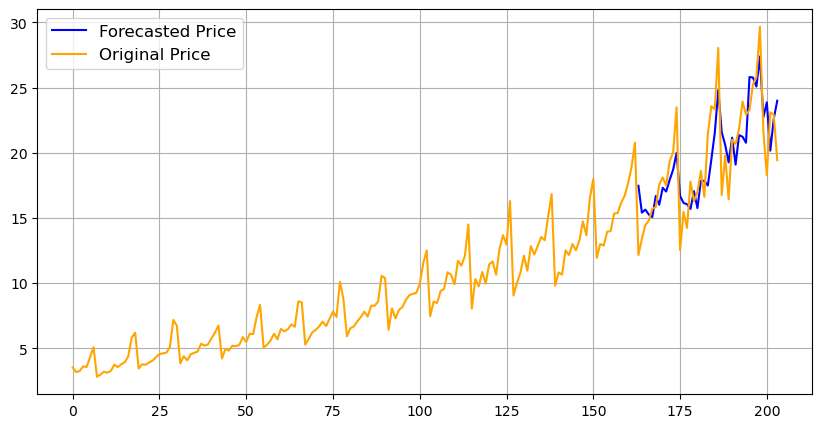

In [21]:
#previsao arima com retroalimentação:
import numpy as np
import matplotlib.pyplot as plt

#one step ahead no conjunto de teste:

# historico pra treinar
history = list(serie_treino)

#so p n resetar o indice
serie_teste2 = serie_teste.reset_index(drop="True")


predictions = []

# Loop para previsões one-step-ahead
for t in range(len(serie_teste)):
    model = SARIMAX(history, order=(0,1,1) , seasonal_order=(0,0,1,12))
    fit = model.fit()
    forecast = fit.forecast(steps=1)[0]  # one step ahead
    predictions.append(forecast)
    history.append(serie_teste2[t])  # atualiza historico


df_pred = pd.DataFrame(predictions, columns=['predictions'], index=serie_teste.index)

df_pred.index = np.array(df_pred.index)  


plt.figure(figsize=(10, 5))  


plt.plot(df_pred.index, df_pred['predictions'], label='Forecasted Price', color='blue')
plt.plot(serie.index, serie, label='Original Price', color='orange')


plt.legend(fontsize=12)


plt.grid(True)  # grade no fundo
plt.show()

In [22]:
mae_sarima = mean_absolute_error(serie_teste, df_pred)
mse_sarima = mean_squared_error(serie_teste, df_pred)
print(f"MAE (arima): {mae_sarima}")
print(f"MSE (arima): {mse_sarima}")

MAE (arima): 1.9860687673054875
MSE (arima): 6.128039048298179


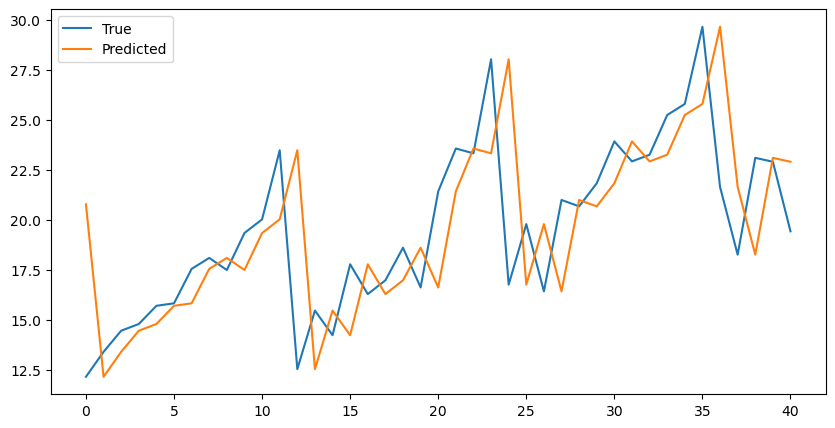

In [23]:
#modelo naive
naive_predictions = [serie_treino.iloc[-1]]  
for i in range(1, len(serie_teste)):
    naive_predictions.append(serie_teste.iloc[i-1])  

plt.figure(figsize=(10, 5))
plt.plot(serie_teste.reset_index(drop="True"), label='True')
plt.plot(naive_predictions, label='Predicted') 
plt.legend()
plt.show()

In [24]:
mae_naive = mean_absolute_error(serie_teste, naive_predictions)
mse_naive = mean_squared_error(serie_teste, naive_predictions)
print(f"MAE (Naive): {mae_naive}")
print(f"MSE (Naive): {mse_naive}")

MAE (Naive): 2.7071010775609756
MSE (Naive): 14.760506990547805


In [25]:
#modelo hibrido: neuralprophet

In [27]:
from neuralprophet import NeuralProphet

In [49]:
m = NeuralProphet(
    n_changepoints=15,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
     n_lags=12,
)


In [50]:
data.rename(columns={'date': 'ds', 'value': 'y'}, inplace=True)

In [51]:
metrics = m.fit(data)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learning rate finder (212). The results might not be optimal.


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

In [52]:
forecast = m.predict(data)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [53]:
m.plot(forecast)


ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [54]:
forecast = forecast.dropna(subset=['yhat1'])
mse = mean_squared_error(forecast['y'], forecast['yhat1'])
mae = mean_absolute_error(forecast['y'], forecast['yhat1'])

print(f"MAE(neuralpropnet): {mae}")
print(f"MSE(neuralpropnet): {mse}")

MAE(neuralpropnet): 0.6252887039871026
MSE(neuralpropnet): 0.7976441562989995
